In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

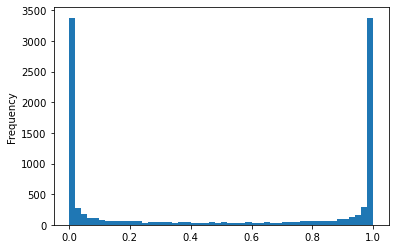

In [2]:
def logit(p):
    return np.log(p/(1-p))

def generate_logit_samples(μ, cov, β0, β, N=100_000):
    # Simulation
    X = np.random.multivariate_normal(μ, cov, size=N)
    ϵ = np.random.normal(size=N)
    log_ps = β0 + X @ β + ϵ
    ps = np.exp(log_ps)/(1+np.exp(log_ps))
    
    # Putting the results into a dataframe for convenience
    samples = pd.DataFrame(X)
    samples.columns = [f'x_{i}' for i in range(1, len(μ)+ 1)]
    samples['p'] = ps
    return samples


ρ12 = 0.5
ρ13 = 0.4
ρ23 = 0.3
cov = [[1, ρ12, ρ13],
       [ρ12, 1, ρ23],
       [ρ13, ρ23, 1]]
μ = np.zeros(3)

β = np.array([1, 2, 8])

samples = generate_logit_samples(μ, cov, 0, β, N=10_000)

pd.Series(samples['p']).plot.hist(bins=50);

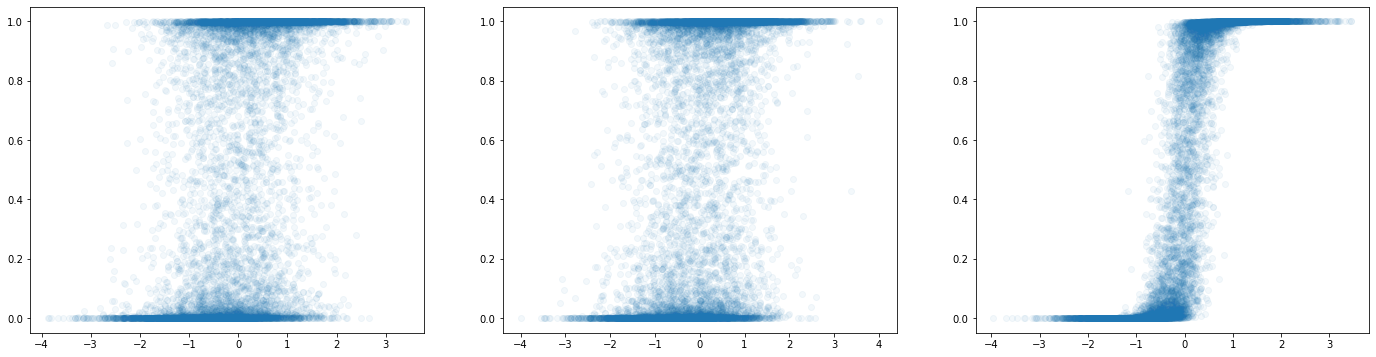

In [3]:
fig, axarray = plt.subplots(1, 3, figsize=(8*3,6))
for i, ax in enumerate(axarray):
    ax.scatter(samples[f'x_{i+1}'], samples['p'], alpha=0.05);
    ax.plot()